# Project 6 - Nematode status assay

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import filters, segmentation, feature, measure
from sklearn.cluster import KMeans
from scipy import ndimage as ndi
from scipy import signal
from PIL import Image
from collections import Counter

# Correct loading

[[86 92 97 ... 91 92 89]
 [87 92 92 ... 91 86 93]
 [88 90 91 ... 90 91 90]
 ...
 [92 91 94 ... 95 94 95]
 [89 94 93 ... 96 94 92]
 [96 93 87 ... 96 92 92]] 2765


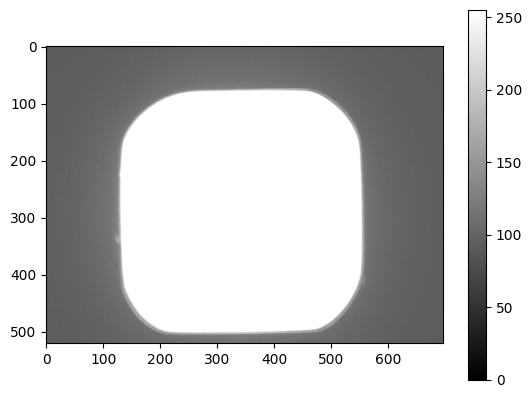

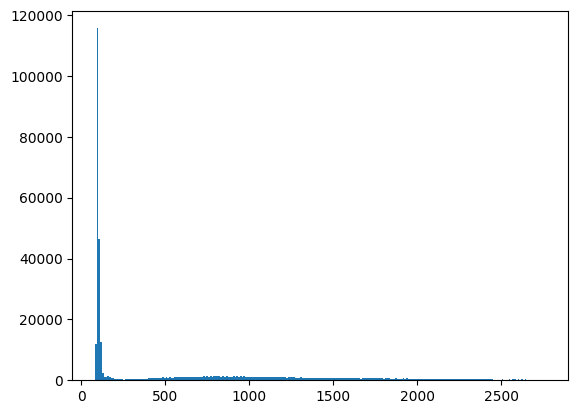

In [4]:
test = Image.open('Data/1649_1109_0003_Amp5-1_B_20070424_A13_w2_F3700E53-0F0F-4721-99FC-B14F70D3CD53.tif')
test_pixels = np.asarray(test)
print(test_pixels, np.max(test_pixels))
plt.imshow(test_pixels, cmap="gray", vmin = 0, vmax = 255)
plt.colorbar()
plt.show()
plt.hist(test_pixels.flatten(), bins = 255)
plt.show()

In [5]:
def stretch(img):
    mini = np.min(img)
    maxi = np.max(img)
    return (255*((img-mini)/(maxi-mini)))

[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 [1 1 0 ... 1 0 0]]


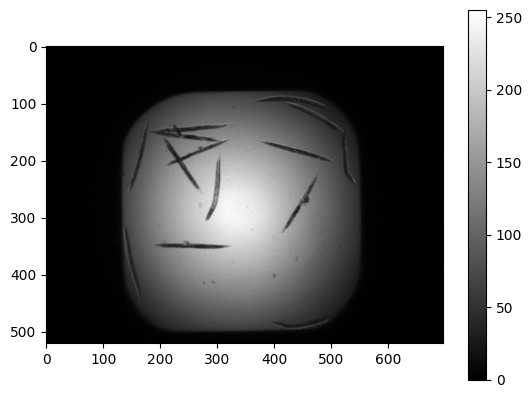

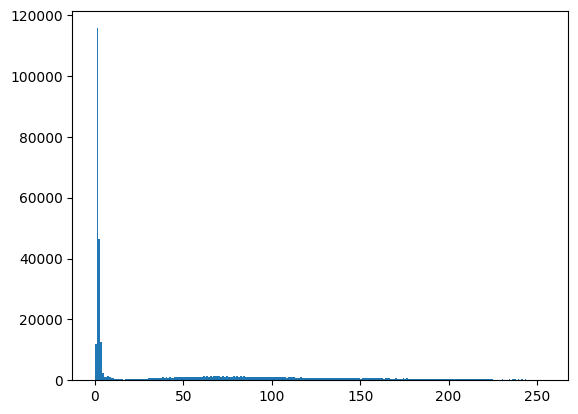

In [6]:
stretch_test_pixel = stretch(test_pixels).astype(int)
print(stretch_test_pixel)

plt.imshow(stretch_test_pixel, cmap="gray", vmin = 0, vmax = 255)
plt.colorbar()
plt.show()
plt.hist(stretch_test_pixel.flatten(), bins = 255)
plt.show()

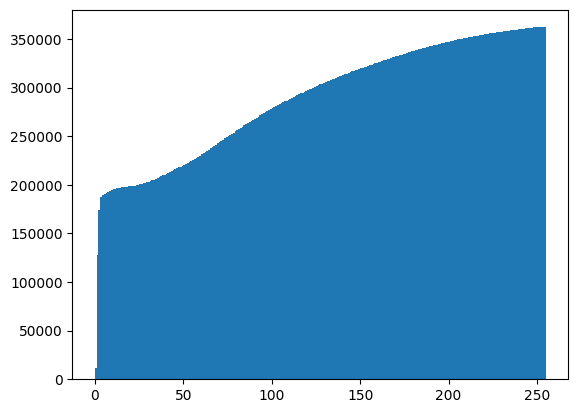

In [7]:
plt.hist(stretch_test_pixel.flatten(), bins = 255, cumulative='T')
plt.show()

# Quality verification

# Segmentation

## Window extraction

In [8]:
window_threshold = 8

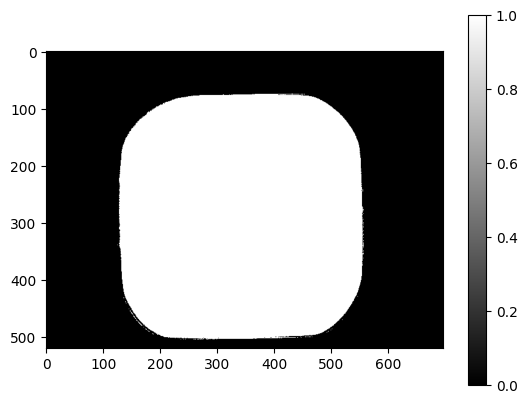

In [9]:
empty_window = stretch_test_pixel>window_threshold
plt.imshow(empty_window, cmap="gray", vmin = 0, vmax = 1)
plt.colorbar()
plt.show()

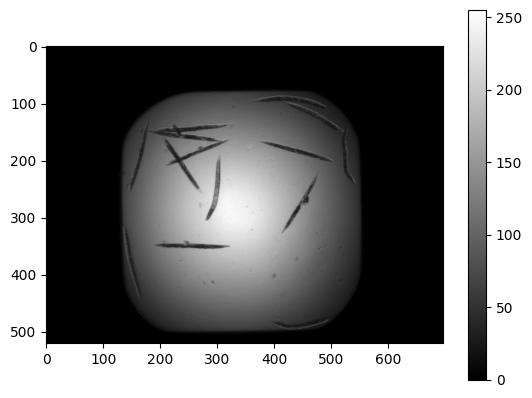

In [10]:
window = empty_window*stretch_test_pixel
plt.imshow(window, cmap="gray", vmin = 0, vmax = 255)
plt.colorbar()
plt.show()

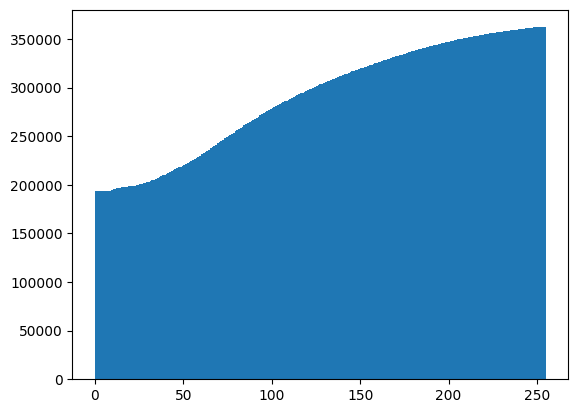

In [11]:
plt.hist(window.flatten(), bins = 255, cumulative='T')
plt.show()

## Do a uniformisation of the luminosity of the window ?

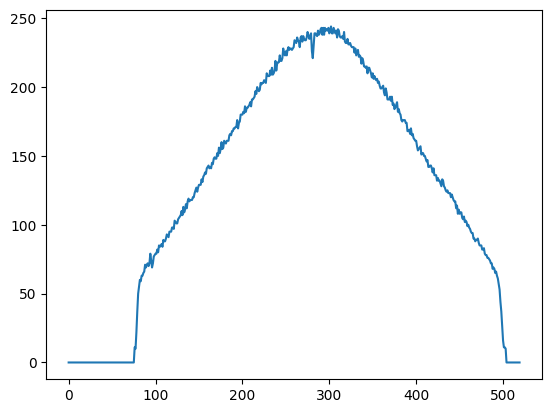

In [12]:
plt.plot(window[:,350])
plt.show()

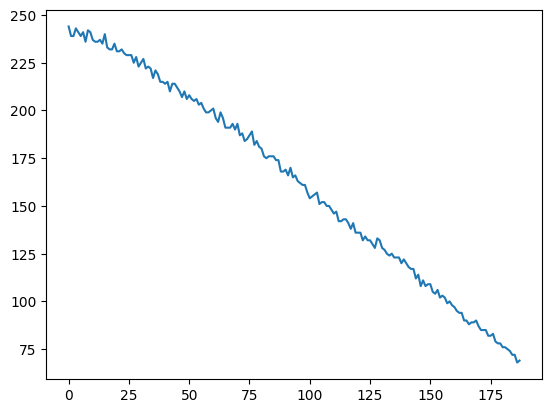

In [13]:
line = window[:,350][np.argmax(window[:,350]):490]
plt.plot(line)
plt.show()

In [14]:
print(np.max(line))
print(np.min(line))
print(len(line))

244
68
188


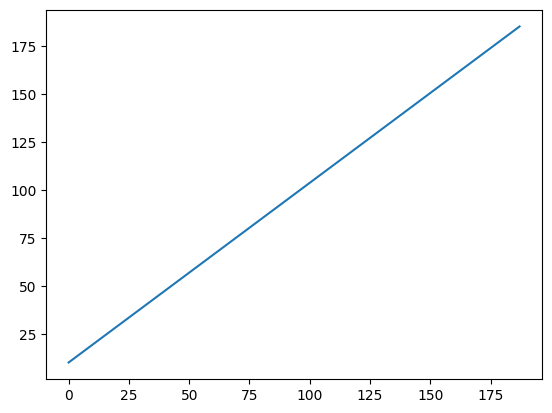

In [15]:
def lum(line,d):
    return 10 + d*(max(line)-min(line))/188

plt.plot(lum(line,np.arange(188)))
plt.show()

In [16]:
n,p = empty_window.shape
barycenter_i = 0
barycenter_j = 0
for i in range(n):
    for j in range(p):
        barycenter_i += empty_window[i,j]*i
        barycenter_j += empty_window[i,j]*j
barycenter_i /= np.sum(empty_window)
barycenter_j /= np.sum(empty_window)
window_center = (int(barycenter_i),int(barycenter_j))
window_center

(290, 341)

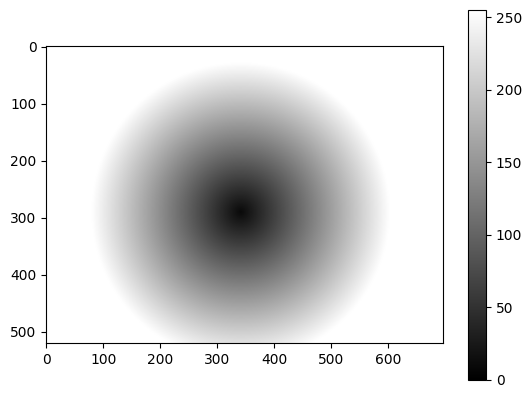

In [17]:
negative_vignetage = np.zeros((n,p))
for i in range(n):
    for j in range(p):
        d = np.sqrt((window_center[0]-i)**2 + (window_center[1]-j)**2)
        negative_vignetage[i,j] = lum(line,d)

plt.imshow(negative_vignetage, cmap="gray", vmin = 0, vmax = 255)
plt.colorbar()
plt.show()

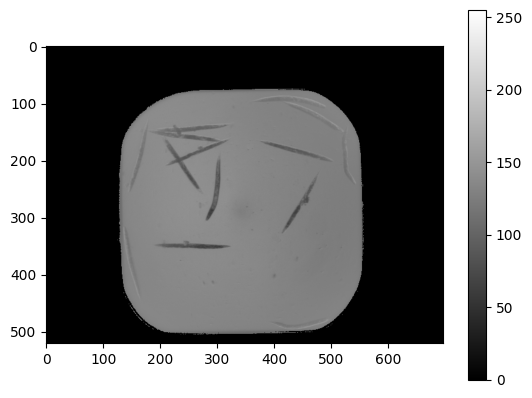

In [18]:
unif_window = (empty_window*(window + negative_vignetage)/2).astype(int)
plt.imshow(unif_window, cmap="gray", vmin = 0, vmax = 255)
plt.colorbar()
plt.show()

## Contour detection

sobel is good because of the brigth countours of nematods ?

### All the contours

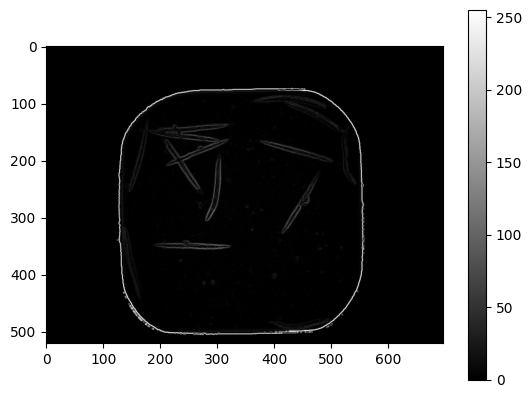

In [19]:
all_contours = stretch(filters.sobel(unif_window))
plt.imshow(all_contours, cmap="gray")
plt.colorbar()
plt.show()

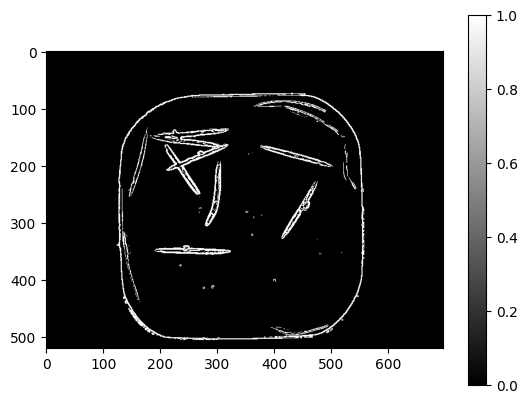

In [20]:
plt.imshow(all_contours>20, cmap="gray")
plt.colorbar()
plt.show()

### Window contours

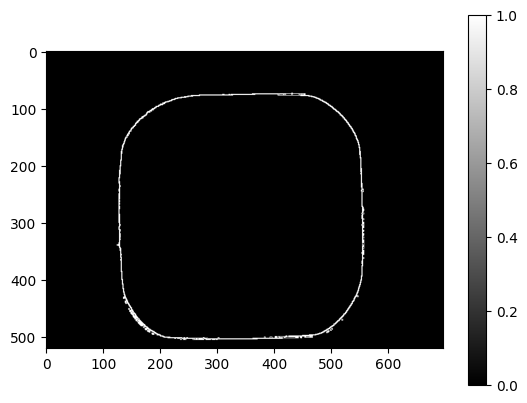

In [21]:
negative_window_contour = stretch(filters.sobel(empty_window))>30
plt.imshow(negative_window_contour, cmap="gray")
plt.colorbar()
plt.show()

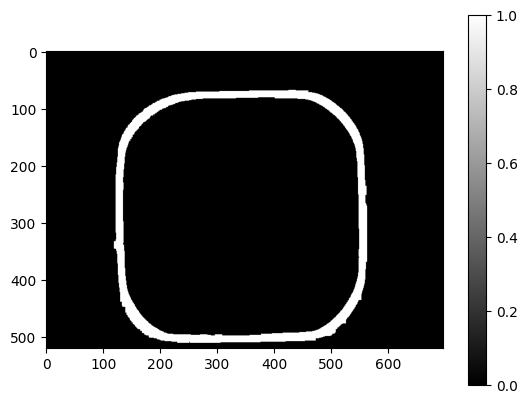

In [22]:
width = 11
wide_negative_window_contour = signal.convolve2d(negative_window_contour,np.ones((width,width)),mode='same')>0
plt.imshow(wide_negative_window_contour, cmap="gray")
plt.colorbar()
plt.show()

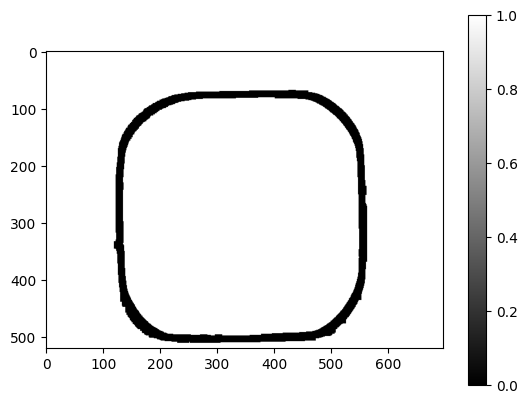

In [23]:
plt.imshow(~wide_negative_window_contour, cmap="gray")
plt.colorbar()
plt.show()

### Nematods contours

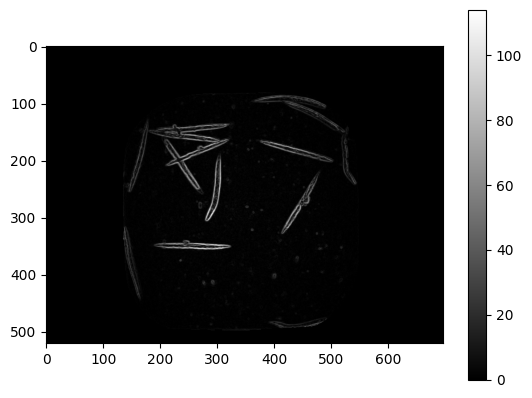

In [24]:
inside_contours = np.multiply(~wide_negative_window_contour,all_contours).astype(int)
plt.imshow(inside_contours, cmap="gray")
plt.colorbar()
plt.show()

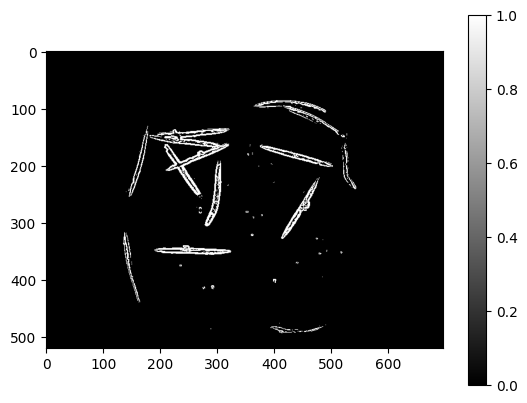

In [25]:
plt.imshow(inside_contours>15, cmap="gray")
plt.colorbar()
plt.show()

## Segmentation

Watershed good because of overlaps ?

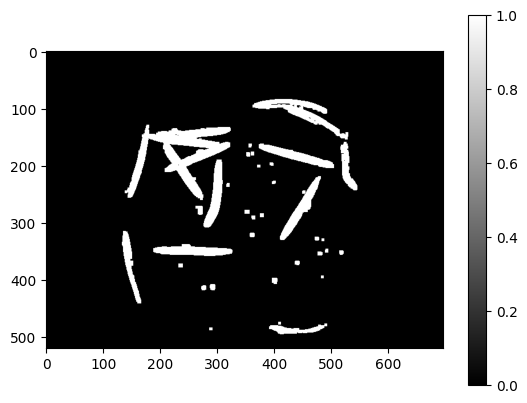

In [26]:
width = 5
nematods = signal.convolve2d((inside_contours>15),np.ones((width,width)),mode='same')>0
plt.imshow(nematods, cmap="gray")
plt.colorbar()
plt.show()

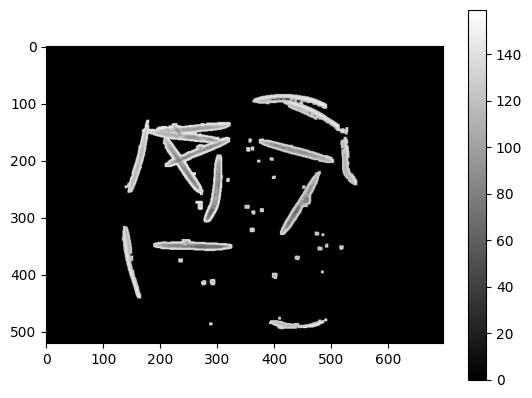

In [27]:
window_segmented = nematods*unif_window
plt.imshow(window_segmented, cmap="gray")
plt.colorbar()
plt.show()

# Tests

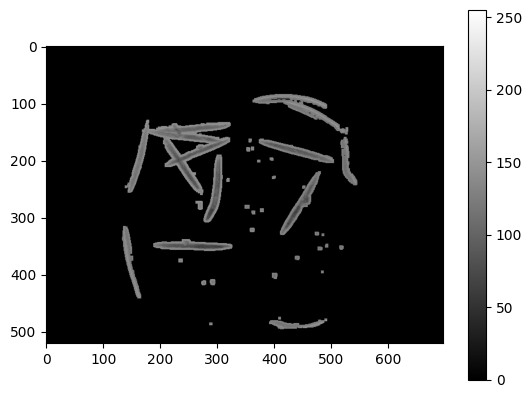

In [28]:
plt.imshow(window_segmented, cmap="gray", vmin = 0, vmax = 255)
plt.colorbar()
plt.show()

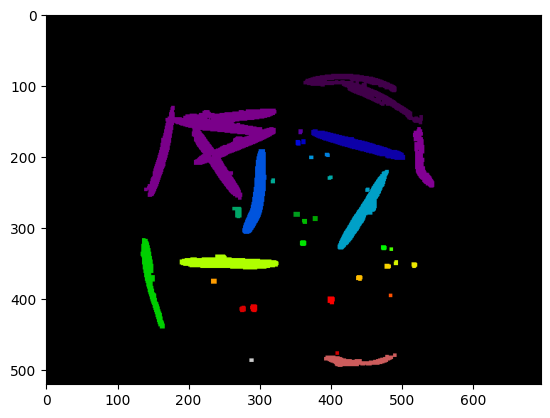

In [29]:
distance30 = ndi.distance_transform_edt(window_segmented)
coords30 = feature.peak_local_max(distance30, footprint=np.ones((1,1)), labels=window_segmented)

mask30 = np.zeros(distance30.shape, dtype=bool)
mask30[tuple(coords30.T)] = True
markers30, _ = ndi.label(mask30)
chev30_watershed = segmentation.watershed(-distance30, markers30, mask=window_segmented)
plt.imshow(chev30_watershed, cmap="nipy_spectral")
plt.show()

# Extraction de descripteurs

In [55]:
def labeling(image):
    binary_image = (image > 0).astype(int)
    labeled = np.zeros_like(binary_image, dtype=int)
    
    label =0 
    equivalences = {}
    
    rows, cols = binary_image.shape
    for r in range(rows):
        for c in range(cols):
            if binary_image[r,c] == 0:
                continue
            
            voisins = []
            for dr in [-1, 0]:
                for dc in [-1, 0, 1]:
                    if dr == 0 and dc == 0:
                        continue
                    rr, cc = r + dr, c + dc
                    if 0 <= rr < rows and 0 <= cc < cols:
                        if labeled[rr, cc] > 0:
                            voisins.append(labeled[rr, cc])
            if not voisins:
                label += 1
                labeled[r, c] = label
                equivalences[label] = {label}
            else:
                def most_common(lst):
                    return max(set(lst), key=lst.count)
                most_common_label = most_common(voisins)
                labeled[r, c] = most_common_label
              
                for n in voisins:
                    equivalences[most_common_label].add(n)
                    equivalences.setdefault(n, set()).add(most_common_label)
        
    label_map = {}
    for k, eq in equivalences.items():
        root = min(eq)
        for e in eq:
            label_map[e] = root

    for r in range(rows):
        for c in range(cols):
            if labeled[r, c] > 0:
                labeled[r, c] = label_map[labeled[r, c]]

    return labeled


In [60]:
labeled_nematods = labeling(distance30)

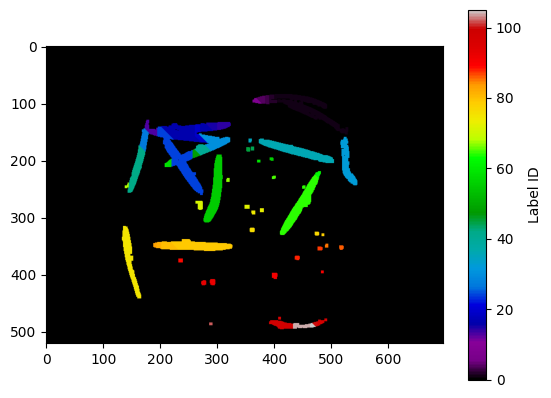

In [61]:
plt.imshow(labeled_nematods, cmap="nipy_spectral")

plt.colorbar(label='Label ID')
plt.show()